<a href="https://colab.research.google.com/github/mkosaka1/capstone_project/blob/master/eda_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
ls

drive/  sample_data/


# Single file

In [ ]:
import librosa
x, sr = librosa.load('/content/drive/My Drive/audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
import librosa
x, sr = librosa.load('/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
print(x.shape)
print(sr)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [ ]:
from IPython.display import Audio

In [ ]:
Audio(data=x, rate=sr)

In [ ]:
single_mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(single_mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
single_mfcc

# Whole Dataset (1440 files)

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split



Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

Video-only (02)

Speech (01)

Fearful (06)

Normal intensity (01)

Statement "dogs" (02)

1st Repetition (01)

12th Actor (12) - Female (as the actor ID number is even)

In [3]:
audio = "/content/drive/My Drive/audio/audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

In [ ]:
audio = "/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/"

actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

In [ ]:
audio

In [4]:
# audio/audio/audio_speech_actors_01-24/Actor_14
# 03-01-02-01-02-01-14.wav

emotion = []
gender = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [5]:
os.listdir(audio + i)

['03-01-06-01-02-02-24.wav',
 '03-01-04-01-02-02-24.wav',
 '03-01-03-02-02-01-24.wav',
 '03-01-06-01-02-01-24.wav',
 '03-01-04-01-01-02-24.wav',
 '03-01-05-02-02-02-24.wav',
 '03-01-04-02-02-01-24.wav',
 '03-01-01-01-01-02-24.wav',
 '03-01-05-02-01-01-24.wav',
 '03-01-06-02-02-01-24.wav',
 '03-01-04-01-01-01-24.wav',
 '03-01-01-01-01-01-24.wav',
 '03-01-05-01-02-02-24.wav',
 '03-01-02-01-02-02-24.wav',
 '03-01-02-02-01-02-24.wav',
 '03-01-07-01-02-01-24.wav',
 '03-01-06-01-01-01-24.wav',
 '03-01-03-01-01-02-24.wav',
 '03-01-03-01-01-01-24.wav',
 '03-01-04-01-02-01-24.wav',
 '03-01-07-01-01-01-24.wav',
 '03-01-06-01-01-02-24.wav',
 '03-01-02-02-01-01-24.wav',
 '03-01-02-01-02-01-24.wav',
 '03-01-05-02-02-01-24.wav',
 '03-01-04-02-01-01-24.wav',
 '03-01-05-01-01-02-24.wav',
 '03-01-04-02-01-02-24.wav',
 '03-01-03-02-02-02-24.wav',
 '03-01-04-02-02-02-24.wav',
 '03-01-03-02-01-02-24.wav',
 '03-01-05-01-01-01-24.wav',
 '03-01-06-02-01-02-24.wav',
 '03-01-02-02-02-02-24.wav',
 '03-01-01-01-

In [6]:
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df
audio_df = pd.concat([pd.DataFrame(gender),audio_df],axis=1)
audio_df.columns = ['gender','emotion']
# audio_df['labels'] =audio_df.gender + '_' + audio_df.emotion
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
# audio_df = audio_df.drop(['gender', 'emotion'], axis=1)
# audio_df.labels.value_counts()
audio_df

# GENDER + EMOTION
# audio_df = pd.DataFrame(emotion)
# audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
# audio_df = pd.concat([pd.DataFrame(gender),audio_df],axis=1)
# audio_df.columns = ['gender','emotion']
# audio_df['labels'] =audio_df.gender + '_' + audio_df.emotion
# audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
# audio_df = audio_df.drop(['gender', 'emotion'], axis=1)
# audio_df.labels.value_counts()

,gender,emotion,path
0,male,fear,/content/drive/My Drive/audio/audio_speech_act...
1,male,neutral,/content/drive/My Drive/audio/audio_speech_act...
2,male,happy,/content/drive/My Drive/audio/audio_speech_act...
3,male,happy,/content/drive/My Drive/audio/audio_speech_act...
4,male,calm,/content/drive/My Drive/audio/audio_speech_act...
...,...,...,...
1435,female,surprise,/content/drive/My Drive/audio/audio_speech_act...
1436,female,disgust,/content/drive/My Drive/audio/audio_speech_act...
1437,female,surprise,/content/drive/My Drive/audio/audio_speech_act...
1438,female,surprise,/content/drive/My Drive/audio/audio_speech_act...


In [8]:
audio_df.to_csv('audio.csv')

In [ ]:

os.listdir(audio)

In [ ]:
fname = audio + 'Actor_02/03-01-01-01-01-01-02.wav'  #female neutral
data_neutral, sr_neutral = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data_neutral, sr=sr_neutral)
ipd.Audio(fname)

In [ ]:
fname = audio + 'Actor_02/03-01-02-01-01-01-02.wav'  #female calm
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)
ipd.Audio(fname)


# MFCC
### The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. MFCC is a good "representation" of the vocal tract that produces the sound. Think of it like an x-ray of your mouth

In [ ]:
fa_mfcc = librosa.feature.mfcc(y=data_neutral, sr=sr_neutral, n_mfcc=13)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(fa_mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
# MFCC
#The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features 
#(usually about 10–20) which concisely describe the overall shape of a spectral envelope.
# good "representation" of the vocal tract that produces the sound. Think of it like an 
# x-ray of your mouth
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)

plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar();

In [ ]:
mfcc.shape

216
216
216
216


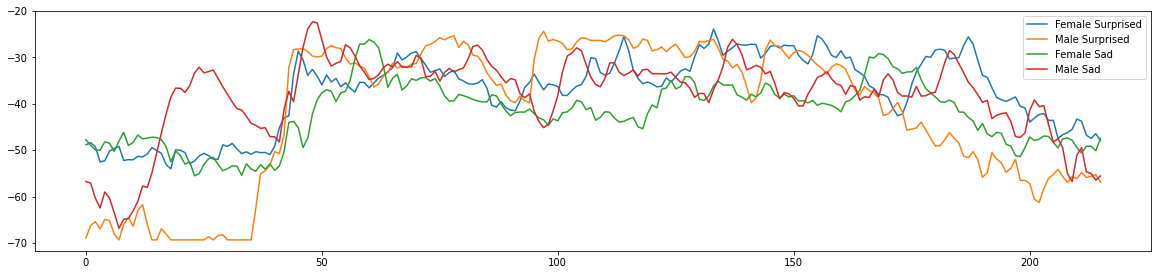

In [9]:
# Male surprised
pathh = audio + 'Actor_09/03-01-08-02-02-02-09.wav'
X, sample_rate = librosa.load(pathh, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Female surprised
path= audio + 'Actor_08/03-01-08-02-02-02-08.wav'
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Male sad
pathh = audio + 'Actor_09/03-01-04-02-02-02-09.wav'
X, sample_rate = librosa.load(pathh, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male1 = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male1 = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male1))

# Female sad
path= audio + 'Actor_08/03-01-04-02-02-02-08.wav'
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
female1 = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female1 = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female1))

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='Female Surprised')
plt.plot(male, label='Male Surprised')
plt.plot(female1, label='Female Sad')
plt.plot(male1, label='Male Sad')
plt.legend()



In [ ]:
# Spectrogram - how the audio spectrum varies as a function of time
spectrogram = librosa.feature.melspectrogram(y=X, sr=sampling_rate)
db_spec = librosa.power_to_db(spectrogram, ref=np.max,)
librosa.display.specshow(db_spec,y_axis='mel', x_axis='time', sr=sampling_rate)
plt.colorbar();

## Feature Extraction

In [49]:
df = pd.DataFrame(columns=['mfcc_feature','spec_feat','chroma_feat'])

counter=0

for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=0)
    
    #get the mel-scaled spectrogram ()
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 0)
    
    #compute chroma energy (pertains to 12 different pitch classes)
    chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    #temporally average chroma
    chroma = np.mean(chroma, axis = 0)
    
    # #compute spectral contrast
    # contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
    # contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
    # which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
    # zcr = librosa.feature.zero_crossing_rate(y=X)
    # zcr = np.mean(zcr, axis= 0)
    
    df.loc[counter] = [mfcc, spectrogram, chroma]
    counter=counter+1   

print(len(df))
df.head()

1440


,mfcc_feature,spec_feat,chroma_feat
0,"[-63.52352959684379, -63.52352959684379, -63.5...","[2.440053844431309e-09, 2.478540403723405e-09,...","[0.7427262094246531, 0.8283234352310781, 0.861..."
1,"[-65.8009712673087, -65.8009712673087, -65.800...","[4.668650934874186e-13, 2.1799963776074315e-11...","[0.8890836152031082, 0.9509049090189307, 0.942..."
2,"[-58.73100684143704, -58.74653122015798, -58.0...","[5.6260320075150826e-08, 4.473663025456934e-08...","[0.5870218278924267, 0.6308990925004826, 0.589..."
3,"[-65.24334603230012, -65.24334603230012, -65.2...","[9.286164115495421e-10, 5.020287711232715e-10,...","[0.8123938350303129, 0.7807005290454773, 0.837..."
4,"[-67.55739512198222, -67.55739512198222, -67.5...","[5.110802400824844e-12, 7.360911965012259e-10,...","[0.6135061143057753, 0.615762566340163, 0.6201..."


In [28]:
df.columns

Index(['mfcc_feature', 'spec_feat', 'chroma_feat', 'contrast_feat'], dtype='object')

In [6]:
df = pd.DataFrame(columns=['mfcc_feature'])

# feature extraction over the entire dataset
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   


print(len(df))
df.head()


1440


,mfcc_feature
0,"[-63.52352959684379, -63.52352959684379, -63.5..."
1,"[-65.8009712673087, -65.8009712673087, -65.800..."
2,"[-58.73100684143704, -58.74653122015798, -58.0..."
3,"[-65.24334603230012, -65.24334603230012, -65.2..."
4,"[-67.55739512198222, -67.55739512198222, -67.5..."


In [ ]:
df_chroma = pd.DataFrame(columns=['chroma_feat'])

# feature extraction over the entire dataset
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    chroma=np.mean(librosa.feature.chroma_stft(X, sr=sample_rate).T,axis=0)
    df_chroma.loc[counter] = [chroma]
    counter=counter+1   


print(len(df_chroma))
df_chroma.head()

In [ ]:
# rmse = librosa.feature.rmse(y=y)
# spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) : DO NOT USE - INDICATES WHERE CENTER OF MASS IS, IS THE SAME FOR HAPPY AND SURPRISED
# spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
# rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
# zcr = librosa.feature.zero_crossing_rate(y)

## CNN

In [51]:
# Extract the mean bands to its own feature columns
df_combined = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist()),
                         pd.DataFrame(df['chroma_feat'].values.tolist()),
                         pd.DataFrame(df['spec_feat'].values.tolist())
                         ],axis=1)
df_combined = df_combined.fillna(0)

In [52]:
df_combined.drop(columns='gender',inplace=True)

In [53]:
df_combined.head()

,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,fear,/content/drive/My Drive/audio/audio_speech_act...,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.377373,-61.595853,-63.160227,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.486761,-63.453534,-60.923158,-58.164801,-58.033787,-57.377220,-58.619264,-57.489921,-57.051144,-58.815463,-59.090078,-58.199690,-57.456970,-53.362825,-48.075103,...,9.470058e-06,2.578390e-05,2.461057e-05,1.202463e-05,5.154764e-06,2.293928e-06,8.568837e-07,1.537127e-06,2.078454e-06,2.184434e-06,3.041122e-06,1.803422e-06,1.143403e-06,7.627434e-07,3.888000e-07,1.779640e-07,1.923068e-07,3.168509e-07,2.245657e-07,2.101146e-07,1.500544e-07,1.671772e-07,1.471501e-07,1.313681e-07,8.375042e-08,3.572479e-08,2.370430e-08,3.129491e-08,2.816052e-08,2.174507e-08,2.531549e-08,1.924894e-08,1.741787e-08,1.225668e-08,7.529888e-09,5.454092e-09,6.819510e-09,1.796941e-08,1.751192e-08,7.574554e-09
1,neutral,/content/drive/My Drive/audio/audio_speech_act...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,-56.435845,...,3.132524e-09,2.293366e-09,1.289942e-09,3.135538e-09,4.808926e-09,9.926860e-09,4.514360e-09,3.569078e-10,3.039941e-10,4.092756e-10,2.502424e-10,8.785423e-11,4.097390e-10,3.496092e-10,8.525146e-11,9.268422e-11,2.479107e-11,1.047995e-10,6.573235e-10,1.409621e-09,3.839809e-10,9.462552e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,happy,/content/drive/My Drive/audio/audio_speech_act...,-58.731007,-58.746531,-58.048578,-57.370804,-58.199914,-59.706633,-59.876183,-59.998060,-59.936650,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.249521,-60.257292,-57.940615,-57.685275,-58.743272,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-59.475713,-59.103223,-56.911964,...,2.422831e-07,1.714550e-07,1.098402e-07,1.919263e-07,2.688476e-07,1.465773e-07,1.096860e-07,9.550388e-08,1.298970e-07,1.184836e-07,1.274261e-07,2.088348e-07,1.981786e-07,1.049217e-07,5.793580e-08,7.813114e-08,8.910524e-08,3.787632e-08,4.967923e-08,5.793108e-08,2.227009e-08,2.370553e-08,2.333633e-08,1.691262e-08,1.855947e-08,2.228112e-08,1.963106e-08,1.471574e-08,2.673383e-08,2.712630e-08,1.231842e-08,7.812410e-09,7.712507e-10,7.638044e-10,1.757530e-09,2.919100e-09,8.747867e-10,4.573883e-10,5.310010e-10,7.820663e-11
3,happy,/content/drive/My Drive/audio/audio_speech_act...,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.117574,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-64.744637,-59.645945,-62.325064,-65.276450,-65.243346,-65.243577,-63.977965,-62.763801,-64.460970,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.235624,-62.331518,-61.644450,-63.583881,-64.115173,-61.981372,...,1.324463e-07,1.342138e-07,2.391723e-07,1.658444e-07,1.556888e-07,1.030683e-07,1.267966e-07,1.693123e-07,1.926444e-07,1.948504e-07,5.296063e-08,3.158196e-08,5.809344e-08,1.287589e-07,1.516797e-07,2.053868e-07,4.422756e-07,3.753533e-07,2.2

In [32]:
# Extract the mean bands to its own feature columns
df = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist())],axis=1)
df=df.fillna(0)

In [54]:
from sklearn.model_selection import train_test_split
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df_combined.drop(['path','emotion'],axis=1)
                                                    , df_combined.emotion
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
1050,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-57.120517,-56.364783,-56.919564,-56.643616,...,4.415681e-01,4.115514e-01,3.644049e-01,3.519298e-01,3.787685e-01,3.931280e-01,3.483175e-01,2.759193e-01,3.521468e-01,3.183150e-01,2.882069e-01,2.535342e-01,1.983086e-01,1.943125e-01,1.990744e-01,1.776476e-01,1.589096e-01,1.553706e-01,1.420108e-01,1.021608e-01,5.034341e-02,1.792324e-02,6.879864e-03,3.412568e-03,3.747550e-03,3.329816e-03,1.948301e-03,1.186611e-03,6.744195e-04,6.094387e-04,5.996702e-04,3.696618e-04,2.078634e-04,1.460218e-04,1.512061e-04,1.460494e-04,7.069810e-05,4.004068e-05,3.365338e-05,3.248373e-05
1089,-54.455935,-53.982046,-54.226074,-54.517805,-54.183947,-53.555767,-53.997486,-53.495771,-53.639700,-52.096820,-51.653162,-52.343873,-52.423225,-53.619529,-56.988470,-58.741522,-57.977533,-57.760244,-55.442507,-54.857142,-55.942796,-58.034943,-59.005747,-60.207708,-61.143465,-62.184965,-64.270296,-67.068375,-65.045721,-66.180034,-66.890461,-61.675594,-59.584528,-59.682429,-62.771199,-60.794746,-59.805362,-59.991111,-58.262969,-57.255646,...,2.136503e-07,3.868777e-07,3.597069e-07,3.391805e-07,3.970744e-07,9.882023e-08,1.788490e-08,2.874086e-08,2.194516e-08,1.974485e-08,1.422010e-08,8.541013e-09,8.241550e-09,7.937044e-10,1.518058e-10,5.500268e-10,9.032455e-09,1.123018e-08,1.883853e-09,1.611077e-09,9.891398e-10,4.389391e-09,7.228003e-08,1.087925e-07,1.635656e-08,7.312348e-08,1.740115e-07,4.704828e-08,5.697175e-09,1.945949e-08,1.272982e-07,1.450795e-07,3.254987e-07,6.365397e-07,8.834527e-07,3.698136e-07,9.759577e-08,1.218991e-07,7.484730e-08,1.697621e-08
1272,-57.705173,-57.728170,-56.672727,-56.152195,-57.413794,-58.473491,-58.040922,-57.550879,-58.224060,-56.276742,-56.079640,-55.957564,-54.278322,-53.695238,-53.886280,-52.937639,-53.013822,-52.019873,-52.774230,-47.967975,-42.985090,-43.805309,-46.216141,-48.206974,-49.704305,-49.842355,-53.794071,-54.537400,-52.456399,-51.819469,-52.689540,-55.331682,-55.172413,-55.627391,-54.902175,-54.397487,-50.447669,-48.340112,-50.558899,-53.784158,...,2.786371e-07,1.708558e-07,2.515469e-07,2.994978e-07,3.014566e-07,2.140986e-07,1.461326e-07,8.668780e-08,2.836540e-08,2.453372e-08,7.513808e-08,1.189310e-07,1.503400e-07,1.522538e-07,1.788531e-07,1.447726e-07,1.134004e-07,8.805186e-08,8.280689e-08,5.931790e-08,2.468415e-08,1.281989e-08,1.868315e-08,4.591137e-08,6.990459e-08,5.130484e-08,3.444039e-08,2.699807e-08,1.129068e-08,1.061053e-08,4.320133e-09,9.739624e-10,6.673323e-10,1.036505e-09,8.970254e-10,1.128038e-09,2.900108e-09,7.032633e-09,8.194183e-09,4.040603e-09
1029,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-70.705346,-70.482046,-69.548357,-64.905299,-64.153173,-65.385524,-66.825837,-68.522927,-67.900706,-66.006895,-67.259607,-68.076803,-66.069587,...,2.230205e-10,3.349858e-10,2.383240e-10,8.282044e-11,4.273849e-10,4.780850e-10,5.582247e-10,4.491637e-10,2.771216e-11,0.000000e+00,0.000000e+00,2.889417e-12,7.094147e-11,3.306415e-10,1.695572e-10,2.945540e-10,6.563323e-10,1.389829e-10,1.518890e-11,1.620437e-10,1.931821e-10,5.145626e-11,3.953893e-11,3.834793e-11,2.834685e-11,1.135194e-12,0.000000e+00,0.000000e+00,0.000

In [34]:
df_combined[df_combined.index.duplicated()]



,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258


In [55]:
#Data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
1050,-0.152501,-0.179350,-0.182549,-0.184854,-0.184736,-0.189496,-0.193138,-0.192895,-0.199666,-0.202813,-0.210843,-0.211954,-0.212181,-0.223067,-0.228339,-0.224896,-0.239190,-0.248439,-0.252818,-0.256354,-0.263357,-0.266160,-0.274353,-0.279398,-0.277571,-0.281908,-0.282872,-0.276972,-0.273258,-0.279328,-0.284646,-0.294050,-0.314828,-0.330799,-0.357896,-0.395245,-0.448920,-0.416202,-0.546934,-0.611405,...,0.202482,0.215873,0.260445,0.279954,0.353057,0.314563,0.218687,0.144193,0.175659,0.103069,0.102066,0.100643,0.057984,0.073832,0.114826,0.144384,0.118918,0.127830,0.152332,0.083425,0.010296,-0.050796,-0.077614,-0.077397,-0.062129,-0.059387,-0.070455,-0.069369,-0.072872,-0.083252,-0.069460,-0.059423,-0.061555,-0.066641,-0.066932,-0.065657,-0.064435,-0.064586,-0.062219,-0.058182
1089,0.163142,0.196127,0.167500,0.131685,0.171464,0.241424,0.179045,0.238710,0.216026,0.395674,0.439425,0.355030,0.343351,0.189149,-0.212912,-0.413650,-0.338897,-0.322703,-0.059100,0.003496,-0.127741,-0.371008,-0.490804,-0.630168,-0.728743,-0.848216,-1.081040,-1.379078,-1.144691,-1.277458,-1.361880,-0.791430,-0.582667,-0.604254,-0.959655,-0.789107,-0.739051,-0.808685,-0.694626,-0.680714,...,-0.108665,-0.115781,-0.135252,-0.137363,-0.137043,-0.127993,-0.122805,-0.116243,-0.110814,-0.108889,-0.112446,-0.111747,-0.107435,-0.110191,-0.111843,-0.114433,-0.109930,-0.106318,-0.109105,-0.097482,-0.105403,-0.105100,-0.100541,-0.085779,-0.067846,-0.064584,-0.075855,-0.073389,-0.075980,-0.087542,-0.073090,-0.061368,-0.062834,-0.067688,-0.067993,-0.066584,-0.064805,-0.064787,-0.062398,-0.058351
1272,-0.221759,-0.252047,-0.128394,-0.067088,-0.220310,-0.353048,-0.302826,-0.244139,-0.331456,-0.102292,-0.087045,-0.073912,0.123955,0.180235,0.149525,0.262168,0.238591,0.343681,0.248939,0.794416,1.364353,1.260552,0.977625,0.733369,0.554155,0.531939,0.088477,0.009207,0.239595,0.304713,0.203913,-0.098723,-0.103069,-0.171424,-0.121658,-0.103348,0.272164,0.452318,0.152349,-0.287591,...,-0.108665,-0.115782,-0.135252,-0.137363,-0.137043,-0.127993,-0.122805,-0.116243,-0.110814,-0.108889,-0.112446,-0.111747,-0.107435,-0.110191,-0.111842,-0.114433,-0.109930,-0.106318,-0.109104,-0.097482,-0.105403,-0.105100,-0.100541,-0.085779,-0.067846,-0.064584,-0.075856,-0.073389,-0.075980,-0.087542,-0.073091,-0.061369,-0.062836,-0.067693,-0.067999,-0.066587,-0.064806,-0.064787,-0.062399,-0.058351
1029,-1.811262,-1.854607,-1.876037,-1.887871,-1.883255,-1.882213,-1.861909,-1.860242,-1.871942,-1.871016,-1.876297,-1.874086,-1.868251,-1.871806,-1.864331,-1.855423,-1.868312,-1.873996,-1.869379,-1.863972,-1.875804,-1.871720,-1.882083,-1.870422,-1.847988,-1.847715,-1.846087,-1.782012,-1.742453,-1.648563,-1.142996,-1.061963,-1.213236,-1.366734,-1.572174,-1.550836,-1.409204,-1.595364,-1.773546,-1.678833,...,-0.108665,-0.115782,-0.135253,-0.137364,-0.137044,-0.127993,-0.122805,-0.116243,-0.110814,-0.108889,-0.112446,-0.111747,-0.107435,-0.110191,-0.111843,-0.114433,-0.109930,-0.106318,-0.109105,-0.097482,-0.105403,-0.105100,-0.100541,-0.085780,-0.067846,-0.064584,-0.075856,-0.073389,-0.075980,-0.087542,-0.073091,-0.061369,-0.062836,-0.067693,-0.067999,-0.066587,-0.064806,-0.064787,-0.062399,-0.058351
1336,-0.166717,-0.193707,-0.197063,-0.199450,-0.199293,-0.204003,-0.207440,-0.207185,-0.213998,-0.217110,-0.225117,-0.226199,-0.226374,-0.237197,-0.242360,-0.238870,-0.253152,-0.262371,-0.266672,-0.270132,-0.277176,-0.279920,-0.288132,-0.293034,-0.291030,-0.295327,-0.296269,-0.290267,-0.285786,-0.292551,-0.297879,-0.307154,-0.317751,-0.286480,-0.165157,-0.095054,-0.006935,-0.006639,0.099555,0.084073,...,-0.108665,-0.115782,-0.135253,-0.137364,-0.137043,-0.127993,-0.122805,-0.116243,-0.110814,-0.108889,-0.112446,-0.111747,-0.107435,-0.110191,

In [66]:
len(X_train)

1080

In [56]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [57]:
y_test

array(['surprise', 'calm', 'calm', 'sad', 'sad', 'angry', 'sad', 'happy',
       'angry', 'neutral', 'disgust', 'disgust', 'happy', 'surprise',
       'sad', 'happy', 'disgust', 'angry', 'calm', 'sad', 'happy', 'calm',
       'neutral', 'calm', 'happy', 'calm', 'disgust', 'disgust',
       'disgust', 'happy', 'disgust', 'fear', 'calm', 'fear', 'surprise',
       'happy', 'fear', 'sad', 'sad', 'neutral', 'happy', 'calm', 'sad',
       'sad', 'angry', 'disgust', 'angry', 'calm', 'happy', 'angry',
       'angry', 'angry', 'surprise', 'happy', 'neutral', 'happy',
       'neutral', 'disgust', 'calm', 'happy', 'fear', 'fear', 'surprise',
       'surprise', 'fear', 'surprise', 'calm', 'disgust', 'fear', 'sad',
       'calm', 'happy', 'disgust', 'happy', 'fear', 'happy', 'calm',
       'fear', 'fear', 'sad', 'calm', 'sad', 'surprise', 'happy', 'fear',
       'calm', 'sad', 'neutral', 'angry', 'happy', 'neutral', 'sad',
       'angry', 'surprise', 'happy', 'surprise', 'disgust', 'angry',
      

In [58]:
len(y_test)

360

In [59]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical

# # one hot encode the target 
# CNN requires input and output are numbers
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = lb.fit_transform(y_test)
y_test = to_categorical(y_test)
print(y_train[0:10])


# lb = LabelEncoder()
# y_train = to_categorical(lb.fit_transform(y_train))
# y_test = to_categorical(lb.fit_transform(y_test))
# print(y_train[0:10])

# # # one hot encode the target 
# lb = LabelEncoder()
# y_train = np_utils.to_categorical(lb.fit_transform(y_train))
# y_test = np_utils.to_categorical(lb.fit_transform(y_test))
# print(y_train[0:10])



[[0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [60]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [61]:
#time series data requires kernel sliding in only one dimension and have spatial properties
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape

# X_train = np.expand_dims(X_train, axis=2)
# X_test = np.expand_dims(X_test, axis=2)
# X_train.shape

(1080, 777, 1)

In [67]:
y_train.shape

(1080, 8)

In [80]:
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM

model = Sequential()
model.add(Conv1D(32, kernel_size=(3), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))
# model.add(Conv1D(64, kernel_size=(3), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = keras.optimizers.Adam(lr=0.0001)




# New model
# model = Sequential()
# model.add(Conv1D(32, 5, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(64, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(64, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(256, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(256, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Flatten())
# model.add(Dense(16)) # Target class number
# model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
# opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
# model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 775, 32)           128       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 773, 64)           6208      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 386, 64)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 386, 64)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 24704)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               3162240   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)              

In [81]:
batch_size=1
epochs=50

In [82]:
# categorical crossentropy since output variable has more than 2 label classes
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/50
1080/1080 [==============================] - 22s 20ms/step - loss: 1.9039 - accuracy: 0.2352 - val_loss: 1.7552 - val_accuracy: 0.3500
Epoch 2/50
1080/1080 [==============================] - 21s 19ms/step - loss: 1.7025 - accuracy: 0.3602 - val_loss: 1.7265 - val_accuracy: 0.3472
Epoch 3/50
1080/1080 [==============================] - 21s 19ms/step - loss: 1.5667 - accuracy: 0.4102 - val_loss: 1.6074 - val_accuracy: 0.4111
Epoch 4/50
1080/1080 [==============================] - 20s 19ms/step - loss: 1.4255 - accuracy: 0.4769 - val_loss: 1.6314 - val_accuracy: 0.3944
Epoch 5/50
1080/1080 [==============================] - 21s 19ms/step - loss: 1.2375 - accuracy: 0.5546 - val_loss: 1.6094 - val_accuracy: 0.4306
Epoch 6/50
1080/1080 [==============================] - 21s 19ms/step - loss: 1.0556 - accuracy: 0.6278 - val_loss: 1.6639 - val_accuracy: 0.4028
Epoch 7/50
1080/1080 [==============================] - 21s 19ms/step - loss: 0.9348 - accuracy: 0.6796 - val_loss: 1.6845 -

In [83]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

12/12 [==============================] - 0s 18ms/step - loss: 4.9948 - accuracy: 0.3972
Loss of the model is -  4.994791507720947
12/12 [==============================] - 0s 17ms/step - loss: 4.9948 - accuracy: 0.3972
Accuracy of the model is -  39.722222089767456 %


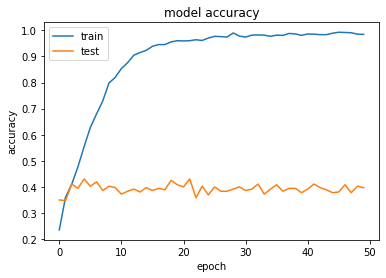

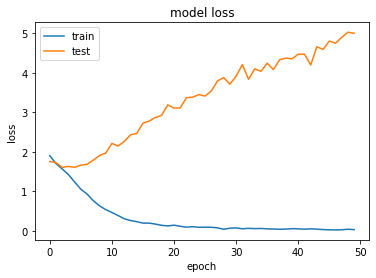

In [86]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#100 epoch
# accuracy: .8620, 38.88
# 0.7935, loss:1.88, 41.94

In [ ]:
# 50 epoch
# val_accuracy = .3972 mfcc
      # .3722 mfcc
# val_accuracy = 0.2139 chroma
# val_accuracy = 0.0639 mfcc + chroma
# 50 epoch - changed random_state
# val_accuracy

In [ ]:
# def extract_feature(file_name, mfcc, chroma, mel):
#     with soundfile.SoundFile(file_name) as sound_file:
#         X = sound_file.read(dtype="float32")
#         sample_rate=sound_file.samplerate
#         if chroma:
#             stft=np.abs(librosa.stft(X))
#         result=np.array([])
#         if mfcc:
#             mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
#             result=np.hstack((result, mfccs))
#         if chroma:
#             chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, chroma))
#         if mel:
#             mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, mel))

In [ ]:
X = df_piczak.drop(['esc'],axis=1)
Y = df_piczak['esc']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

In [ ]:
# ranfom forest on MFCC features
rfc_mfcc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2,n_jobs=-1, random_state=42)
rfc_mfcc.fit(X_train,Y_train)

## MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score




In [ ]:
# Extract the mean bands to its own feature columns
df = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist())],axis=1)
df=df.fillna(0)

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=22
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

In [ ]:
model=MLPClassifier(alpha=0.01, batch_size=216,epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [ ]:
#DataFlair - Calculate the accuracy of our model
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

## RFC

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=22
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

In [ ]:
from sklearn import model_selection
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring=’roc_auc’)


In [ ]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = [‘auto’, ‘sqrt’]

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 ‘n_estimators’: n_estimators,
 ‘max_features’: max_features,
 ‘max_depth’: max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

In [ ]:
#preparing data
train_data = pd.DataFrame()
train_data['fname'] = train['fname']
test_data = pd.DataFrame()
test_data['fname'] = audio_test_files

train_data = train_data['fname'].apply(get_mfcc, path='../input/audio_train/')
print('done loading train mfcc')
test_data = test_data['fname'].apply(get_mfcc, path='../input/audio_test/')
print('done loading test mfcc')

train_data['label'] = train['label']
test_data['label'] = np.zeros((len(audio_test_files)))